### Import stuff

In [175]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 
from scipy import optimize
import time
from tqdm import tqdm
from saxs import ScatterData
from methods import *
from plot_utils import *
from scipy.signal import savgol_filter
import warnings
warnings.filterwarnings('ignore')
import mrcfile 

# Load data

## Load diff data from EuXFEL

In [6]:
# Path where XFEL data is 
XFEL_path = '/home/leonardo/SAXS_222711/data_csv/Hamburg_data'

# Get the time points of the the data, as well as time resolved data
time_points = np.array([float(file.replace('us_averaged.npy','')) for file in os.listdir(XFEL_path) if 'us' in file])
XFEL_tr = np.array([os.path.join(XFEL_path,file) for file in os.listdir(XFEL_path) if 'us' in file])

# Sort from slowest timpoints to the fastest timepoints. 
sort_ind = np.argsort(time_points)[::-1]
time_points = time_points[sort_ind]
XFEL_tr = XFEL_tr[sort_ind]

# Keep ScatterData in list for easy access 
XFEL_empty = [ScatterData() for i in range(XFEL_tr.shape[0])]
# Load q vector from XFEL 
XFEL_q = np.load(f'/home/leonardo/SAXS_222711/data_csv/Hamburg_data/q.npy')

# Iterate over time resolved data and set I and q for ScatterData
XFEL_data = []
for data,i in zip(XFEL_empty, XFEL_tr):
    intensity = np.load(i)
    data.set_data(XFEL_q,intensity)
    datya = data.remove_nan()
    XFEL_data.append(data)
print(time_points)

[269.51 223.41 180.85 136.53  92.2   47.88   3.55]


## Load SAXS data - Measurement 1, FEB 2023

In [80]:
#Load data from Diamond 20C 15mg/ml
dark_path = '/home/leonardo/SAXS_DATA_FEB23/AsLOV2_measurement1_Dark_sub/csv'
light_path = '/home/leonardo/SAXS_DATA_FEB23/AsLOV2_measurement1_Light_sub/csv'

# Get the data from files and creates ScatterData object that are stored in lists
dark_files = np.array([os.path.join(dark_path,file) for file in os.listdir(dark_path)])
light_files = np.array([os.path.join(light_path,file) for file in os.listdir(light_path)])
time_steady = [10,10,20,20]

SAXS_dark_steady = []
SAXS_light_steady = []
SAXS_diff_steady = []
                       
for light, dark in zip(light_files,dark_files):
    dark = ScatterData(dark)
    light = ScatterData(light)
    diff_SAXS = calc_diff(light,dark)
    SAXS_dark_steady.append(dark)
    SAXS_light_steady.append(light)
    SAXS_diff_steady.append(diff_SAXS)
    


## Load SAXS data - Measurement 2, FEB 2023

In [78]:
dark_path = '/home/leonardo/SAXS_DATA_FEB23/AsLOV2_sample2/Dark/csv'
light_path = '/home/leonardo/SAXS_DATA_FEB23/AsLOV2_sample2/Light/csv'
buffer_dark = '/home/leonardo/SAXS_DATA_FEB23/AsLOV2_buffer/csv/dark_buffer'
buffer_light = '/home/leonardo/SAXS_DATA_FEB23/AsLOV2_buffer/csv/light_buffer'


dark_files = [os.path.join(dark_path,file) for file in os.listdir(dark_path)]
light_files = [os.path.join(light_path,file) for file in os.listdir(light_path)]
dark_buffer = [os.path.join(buffer_dark,file) for file in os.listdir(buffer_dark)]
light_buffer = [os.path.join(buffer_light,file) for file in os.listdir(buffer_light)]

dark_files.sort()
light_files.sort()
dark_buffer.sort()
light_buffer.sort()



time_illumination = [1,2,5,10]
SAXS_dark_illumination = []
SAXS_light_illumination = []
SAXS_diff_illumination = []
                       
for light, dark, light_buffer, dark_buffer in zip(light_files, dark_files, light_buffer, dark_buffer):
    dark = ScatterData(dark)
    #dark = calc_diff()
    light = ScatterData(light)

    
    diff_SAXS = calc_diff(light,dark)
    SAXS_dark_illumination.append(dark)
    SAXS_light_illumination.append(light)
    SAXS_diff_illumination.append(diff_SAXS)
    


## Load SAXS - Temperature experiment Nov 22

In [4]:
temp_saxs_path = '/home/leonardo/SAXS_222711/data_csv/temperature_exp'
temperatures = np.array([int(file.replace('AsLOV2_15mgml_','').replace('C_average_average.dat.csv','')) for file in os.listdir(temp_saxs_path)])
temp_saxs = np.array([os.path.join(temp_saxs_path,file) for file in os.listdir(temp_saxs_path)])

# Sort temperature from highest to lowest as well as the data files
sort_ind = np.argsort(temperatures)[::-1]
temperatures = temperatures[sort_ind]
temp_saxs = temp_saxs[sort_ind]
SAXS_temp = [ScatterData(file) for file in temp_saxs]

## Load absolute data from XFEL

In [7]:
#Load Dark and Light data from XFEL
dark_path = '/home/leonardo/SAXS_222711/data_csv/Hamburg_data/Dark'
light_path = '/home/leonardo/SAXS_222711/data_csv/Hamburg_data/Light'

dark_files = np.array([os.path.join(dark_path,file) for file in os.listdir(dark_path)])
light_files = np.array([os.path.join(light_path,file) for file in os.listdir(light_path)])

buffer_dark = np.load('/home/leonardo/SAXS_222711/data_csv/Hamburg_data/Buffer_off_runr0133.npy')
buffer_light =np.load('/home/leonardo/SAXS_222711/data_csv/Hamburg_data/Buffer_on_runr0133.npy')

buffer_light = np.nansum(buffer_light[150:175,:],axis = 0)/25
buffer_dark =np.nansum(buffer_dark[150:175,:],axis = 0)/25

darks = np.zeros((5,176,XFEL_q.shape[0]))
lights = np.zeros((5,176,XFEL_q.shape[0]))

for i,states in enumerate(zip(dark_files, light_files)):
    dark,light = states
    d = np.load(dark)
    l = np.load(light)
    darks[i] = d[:176]
    lights[i] = l[:176]

dark = (np.sum(darks,axis=0))/len(dark_files)
dark = np.sum(dark[150:175,:],axis = 0)/25

light = (np.sum(lights,axis=0))/len(light_files)
light = np.sum(light[150:175,:],axis = 0)/25

# Factor of 0.935 for buffer subtraction matching the SAXS baseline 
XFEL_dark = buffer_sub(dark, buffer_dark,XFEL_q,.935)
XFEL_dark_theo = buffer_sub(dark, buffer_dark,XFEL_q,.91)
XFEL_light= buffer_sub(light, buffer_light,XFEL_q,.935)

XFEL_light = XFEL_light.remove_nan()
XFEL_dark_theo = XFEL_dark_theo.remove_nan()
XFEL_dark = XFEL_dark.remove_nan()



## Plot data for verification

### Plot buffer subtracted data

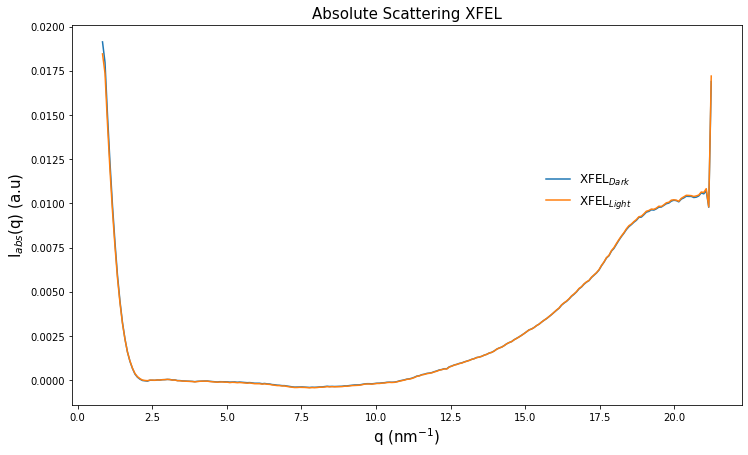

In [167]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
ax.plot(XFEL_dark.q,XFEL_dark.i, label=r'XFEL$_{Dark}$')
ax.plot(XFEL_light.q,XFEL_light.i, label=r'XFEL$_{Light}$')
ax.legend(loc=(0.7, 0.5), frameon=False, fontsize=12)
ax.set_title('Absolute Scattering XFEL', fontsize=15)
ax.set_ylabel(r'I$_{abs}$(q) (a.u)', fontsize=15)
ax.set_xlabel(r'q (nm$^{-1}$)', fontsize=15)
plt.show()




### Plot Diff data XFEL

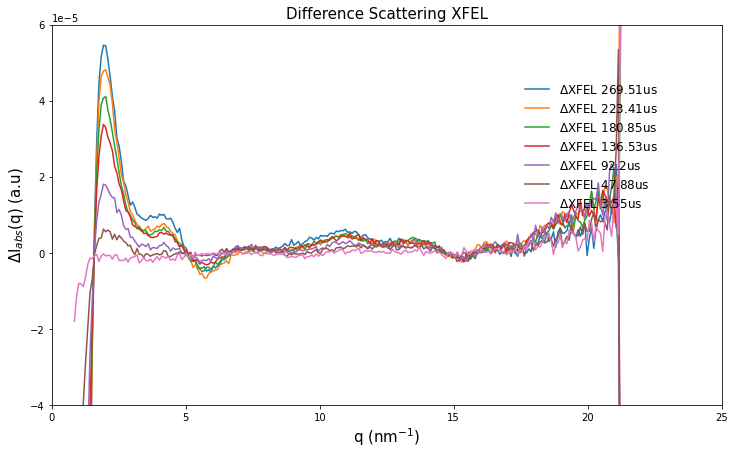

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
for data , time in zip(XFEL_data, time_points):
    ax.plot(data.q,data.i, label=r'$\Delta$XFEL '+str(time)+'us')
ax.legend(loc=(0.7, 0.5), frameon=False, fontsize=12)
ax.set_title('Difference Scattering XFEL', fontsize=15)
ax.set_ylabel(r'$\Delta$I$_{abs}$(q) (a.u)', fontsize=15)
ax.set_xlabel(r'q (nm$^{-1}$)', fontsize=15)
ax.set_ylim([-4e-5,6e-5])
ax.set_xlim([data.q[0],25])
plt.show()


# Temperature differences

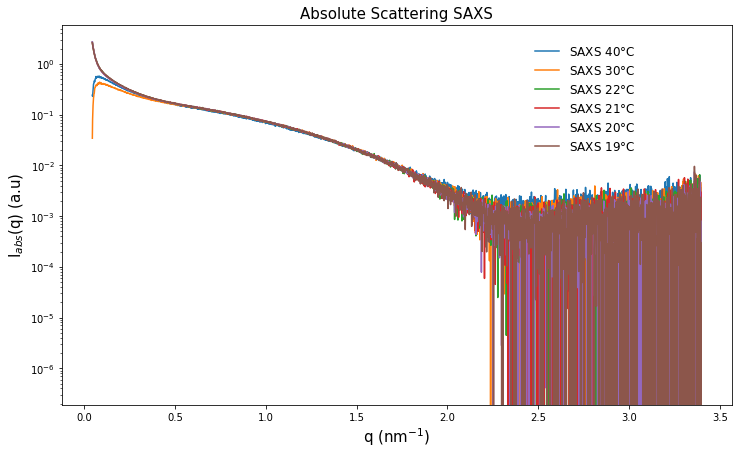

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
for data , temp in zip(SAXS_temp, temperatures):
    ax.plot(data.q*10,data.i, label=r'SAXS '+str(temp)+r'$\degree$C')
ax.legend(loc=(0.7, 0.65), frameon=False, fontsize=12)
ax.set_title('Absolute Scattering SAXS', fontsize=15)
ax.set_ylabel(r'I$_{abs}$(q) (a.u)', fontsize=15)
ax.set_xlabel(r'q (nm$^{-1}$)', fontsize=15)
ax.set_yscale('log')

plt.show()

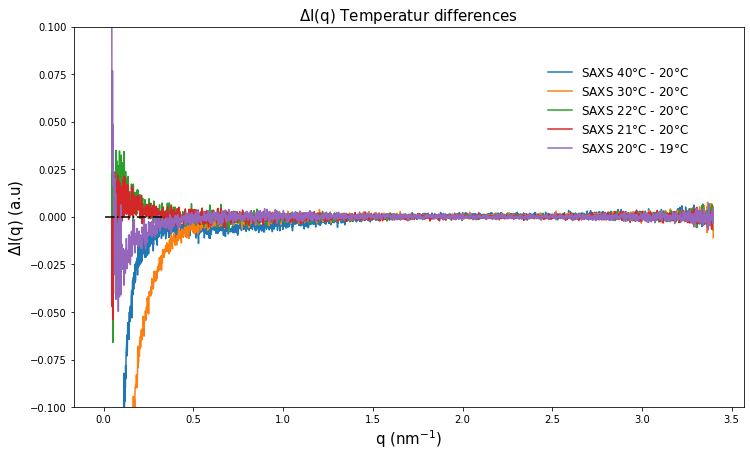

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
for data , temp in zip(SAXS_temp, temperatures):
    if data == SAXS_temp[4]:
        continue
    if data == SAXS_temp[-1]:
        ax.plot(data.q*10,SAXS_temp[4].i-data.i, label=r'SAXS '+str(temperatures[4])+r'$\degree$C - '+str(temp)+r'$\degree$C')
    else:
        ax.plot(data.q*10,data.i-SAXS_temp[4].i, label=r'SAXS '+str(temp)+r'$\degree$C - '+str(temperatures[4])+r'$\degree$C')
ax.legend(loc=(0.7, 0.65), frameon=False, fontsize=12)
ax.set_title('$\Delta$I(q) Temperatur differences', fontsize=15)
ax.set_ylabel(r'$\Delta$I(q) (a.u)', fontsize=15)
ax.set_xlabel(r'q (nm$^{-1}$)', fontsize=15)
ax.hlines(0, xmin = data.q[0], xmax = 0.34, color='k', linestyle='-.')
ax.set_ylim([-.1,.1])

plt.show()

# AlphaFold2 Models


## AF2 load data

In [8]:
AF2_path = '/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/intensities/fixed'
names = [file for file in os.listdir(AF2_path)]
names.sort()
files = np.array([os.path.join(AF2_path,file) for file in os.listdir(AF2_path)])
ind = np.argsort(files)
AF2_data = np.array([ScatterData(file) for file in files])
AF2_data = AF2_data[ind]

## Main function for calculating various metrics

In [3]:
def calc_metrics(q_min,q_max,k,n): 
    
    save_path = '/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/new_note_book'
    # Adjust exp. difference data to q-range 
    exp_diff_cut = XFEL_data_theo[0].cut_q(q_min,q_max)
    exp_diff_cut = exp_diff_cut.remove_nan()

    exp_dark_cut = XFEL_dark.cut_q(q_min,q_max)
    exp_dark_cut = exp_dark_cut.remove_nan()
    
    theory_ref = AF2_data[0].scale_q(10)
    theory_ref= theory_ref.cut_q(q_min,q_max)
    
    # Interpolate exp. difference data
    exp_diff_interpolated = interpolate(theory_ref.q,exp_diff_cut)
    exp_diff_interpolated_scaled_I = exp_diff_interpolated.scale_intensity(1e5)
    exp_diff_interpolated_scaled_cc = exp_diff_interpolated.scale_intensity(1/exp_diff_interpolated.q)
    
    # Interpolate exp. absolute data
    exp_abs_interpolated = interpolate(theory_ref.q,XFEL_dark)
    exp_abs_interpolated_scaled_I = exp_abs_interpolated.scale_intensity(1e5)
    #Define list with metrics
    corr_final = []
    R2 = []
    fopts = []
    light_index = []
    dark_index = []
    occupancies = []
    diff_scale = []
    abs_scale = []
    
    print(f'Running {2000-n} models')
    # Iterate over each model in the list of models
    for model1 in tqdm(AF2_data[n:]):
        index1 = n 
        n += 1
        index2 = n
        # Iterate over the models after current model to calculate half difference matrix
        for model2 in AF2_data[index2:]:    
            if model1 == model2:
                continue
            # Scale the data with 1/q to maximize the small q region 
            theory_diff = calc_diff(model1, model2)
            theory_diff = theory_diff.scale_q(10)
            theory_diff = theory_diff.cut_q(q_min,q_max)
            theory_scaled_cc = theory_diff.scale_intensity(1/theory_diff.q)
            #print(theory_scaled_cc.i/theory_diff.q)
            
            # Scale exp. diff and exp. abs to theory (factor of 1*e5 for faster calc.)
            scale_diff,fopt_diff = SSE(exp_diff_interpolated_scaled_I.i,theory_diff.i, 0.0002)
            
            # To find which model is dark and light 
            if scale_diff > 0:
                model1_adjusted = model1.scale_q(10)
                model1_adjusted = model1_adjusted.cut_q(q_min,q_max)
                scale_abs,fopt_abs = SSE(exp_abs_interpolated_scaled_I.i, model1_adjusted.i, 0.0002)
                light_index.append(index1)
                dark_index.append(index2)
            else:
                model2_adjusted = model2.scale_q(10)
                model2_adjusted = model2_adjusted.cut_q(q_min,q_max)
                scale_abs,fopt_abs = SSE(exp_abs_interpolated_scaled_I.i, model2_adjusted.i, 0.0002)
                light_index.append(index2)
                dark_index.append(index1)
                
            
            # Calculate the R2 between intepolated experimental curve and the theoretical curve
            r2= calc_r2(exp_diff_interpolated.i/scale_diff, theory_diff.i/1e5)
            # Calc Pearson CC
            corr = np.corrcoef(exp_diff_interpolated_scaled_cc.i,theory_diff.i, rowvar=True)[0][1]            
            # Calc occupance
            occupancy = (scale_diff/scale_abs)[0]
            diff_scale.append(scale_diff)
            corr_final.append(corr)
            abs_scale.append(scale_abs)
            R2.append(r2)
            fopts.append(fopt_diff/scale_diff[0])
            occupancies.append(occupancy)
            index2 += 1
            
    np.save(f'{save_path}/occupancy', occupancies)
    np.save(f'{save_path}/correlations',corr_final)
    np.save(f'{save_path}/R2',R2)
    np.save(f'{save_path}/fopts',fopts)
    np.save(f'{save_path}/light_index',light_index)
    np.save(f'{save_path}/dark_index',dark_index)
    np.save(f'{save_path}/diff_scales',diff_scale)
    np.save(f'{save_path}/abs_scales',abs_scale)
    
    # For testing 
    #fig1, ax = plt.subplots(1, 1, figsize=(12, 7))
    #ax.plot(theory_diff.q, theory_diff.i, linewidth=3.0,label='Theory', marker='o')
    #ax.plot(exp_diff_interpolated_scaled_I.q, exp_diff_interpolated_scaled_I.i/scale_diff, linewidth=2.0,label='XFEL_interpolated')
    #ax.plot(XFEL_data[0].q, XFEL_data[0].i, linewidth=2.0,label='XFEL_raw')
    #ax.plot(exp_diff_interpolated.q, exp_diff_interpolated.i, linewidth=2.0,label='XFEL')    
    #ax.set_title('$\Delta$I(q)',fontsize=15)
    #ax.set_ylabel('Intensity (a.u.)',fontsize=15)
    #ax.set_ylim([-.00001,.000065])
    #ax.set_xlabel('q (nm$^{-1}$)',fontsize=15)
    #ax.legend(loc=(0.75,0.05), frameon = True,fontsize=10)
    
    
    


## Run Main Func. ~ 1h 


In [28]:
import time
start=time.time()
k=0
n=0
q_max = 20
q_min = np.nanmin(XFEL_data[0].q[10])
calc_metrics(q_min,q_max,k,n)
end_time=time.time()
ex_time=round(end_time-start,3)
print(f'Run time: {ex_time} seconds for {2000-n} models')


Running 2000 models


100%|███████████████████████████████████████| 2000/2000 [53:23<00:00,  1.60s/it]


Run time: 3206.698 seconds for 2000 models


## Main function for plotting data

### Data path for variables

In [91]:
data_dir = '/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/new_note_book/'

### Func

In [11]:
def make_plots(x, qmax, qmin):
    # Adjust Theoretical q
    theory_ref = AF2_data[0].scale_q(10)
    theory_ref= theory_ref.cut_q(q_min,q_max)
    
    # Adjust XFEL q and data 
    exp_diff_cut = XFEL_data[0].cut_q(q_min,q_max)
    exp_diff_cut = exp_diff_cut.remove_nan()

    #Path where figures are stored
    save_path = '/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/new_note_book/plots'
    
    # Start retrieving data   
    data_dir = '/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/new_note_book'
    r2 = np.load(f'{data_dir}/R2.npy')
    corr = np.load(f'{data_dir}/correlations.npy')
    light_index = np.load(f'{data_dir}/light_index.npy')
    dark_index = np.load(f'{data_dir}/dark_index.npy')
    store_rgs(data_dir)
    rgs = np.load(f'{data_dir}/rgs.npy')
    activation_factor = np.load(f'{data_dir}/occupancy.npy')
    scales = abs(np.load(f'{data_dir}/diff_scales.npy'))
    rg_diff = get_rg_diff(light_index, dark_index, rgs)
    
    # Order data according to metric
    best_indices = r2.argsort()[-x:]
 
    # Initiate main plot
    fig1, ax = plt.subplots(1, 1, figsize=(12, 7))
    
    # Loop over best models and plot    
    plotter(best_indices, light_index, dark_index, scales, AF2_data, ax, q_min, q_max)
    # XFEL Plot
    ax.plot(exp_diff_cut.q, exp_diff_cut.i, linewidth=6.0, color='Red', label='Experimental')
    # Add labels, axes, legends, title, etc. 
    ax.set_title(f' Top {x} difference models based on R²', fontsize=15)
    ax.set_ylabel(f'$\Delta$I(q) (a.u)',fontsize=15)
    ax.set_xlabel('q (nm$^{-1}$)',fontsize=15)
    #ax.xlim([.8,25])
    ax.legend(loc=(0.5,0.1), frameon = True,fontsize=15)
    # Save plot
    plt.savefig(f'{save_path}/Top_{x}.png',bbox_inches='tight',facecolor=(1, 1, 1))
    
    # Plot R² 
    plot_r2(r2, save_path, True)
    
    # Plot activation factor
    plot_activation_factor(activation_factor, save_path, True)
    
    # Plot occupancy Vs. R²
    plot_r2_activation(r2, activation_factor, save_path, True,True)
     
    # Plot difference in Rg Vs. R2
    plot_rg_diff_r2(rg_diff,r2, save_path, True)
    
    # Plot difference in Rg Vs. activation factor
    plot_rg_diff_activation(rg_diff, activation_factor, save_path, True)
    
    
    # Plot curves after cut off
    fig1, ax1 = plt.subplots(1, 1, figsize=(12, 7))
    best_activation = np.argwhere(abs(activation_factor) <1)
    best_r2 = np.argwhere(r2>0.2)
    best_indices = np.intersect1d(best_r2,best_activation)
    best_indices = np.arange(r2.shape[0])[best_indices]
    plotter(best_indices, light_index, dark_index, scales, AF2_data, ax1, q_min, q_max) 
    # XFEL Plot
    ax1.plot(exp_diff_cut.q, exp_diff_cut.i, linewidth=6.0, color='Red', label='Experimental')
    # Add labels, axes, legends, title, etc. 
    ax1.set_title(f' Top {best_indices.shape[0]} difference models based on R² > 0.2 and yield < 1', fontsize=15)
 
    ax1.set_ylabel(f'$\Delta$I(q) (a.u)',fontsize=15)
    ax1.set_xlabel('q (nm$^{-1}$)',fontsize=15)
    ax1.legend(loc=(0.5,0.1), frameon = True,fontsize=15)
    # Save plot
    plt.savefig(f'{save_path}/activation_cut.png',bbox_inches='tight',facecolor=(1, 1, 1))    

### Run - Main

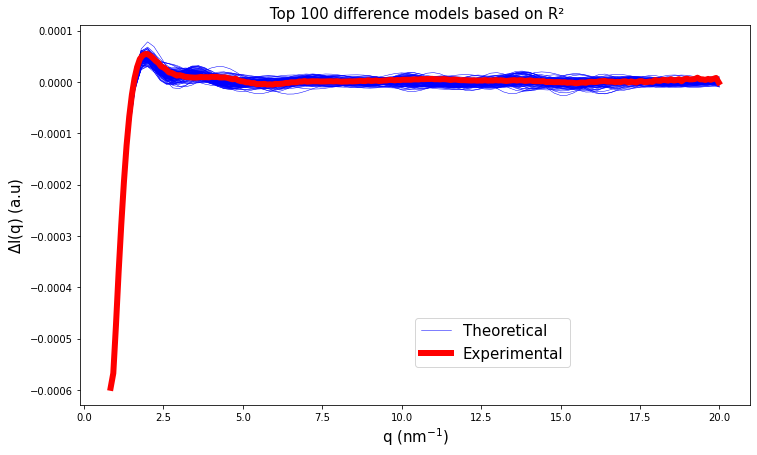

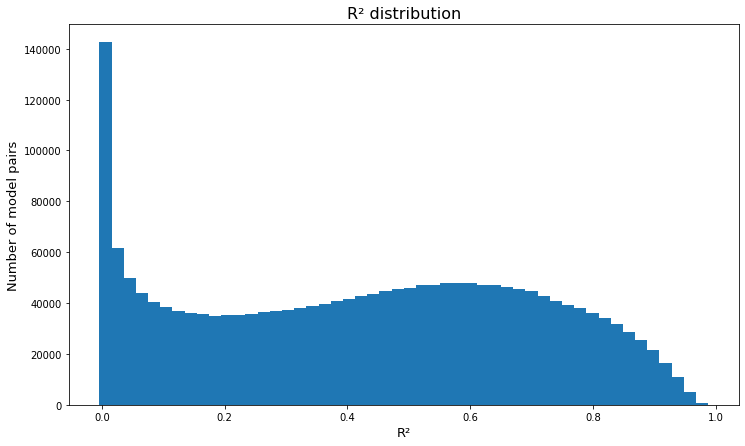

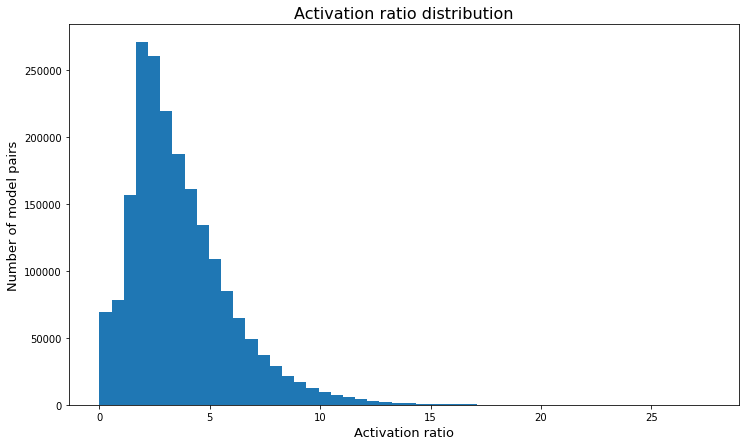

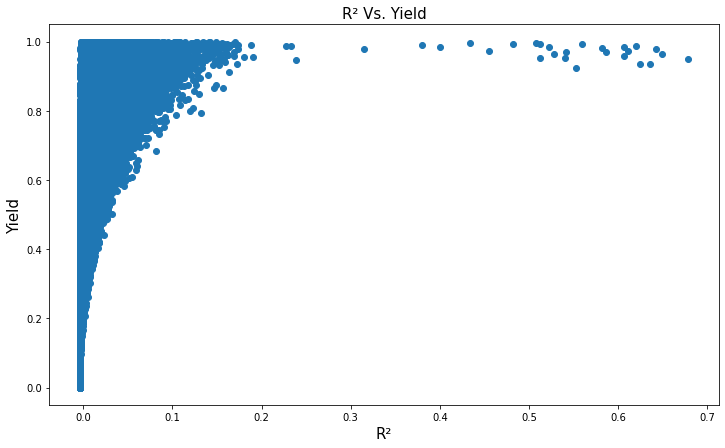

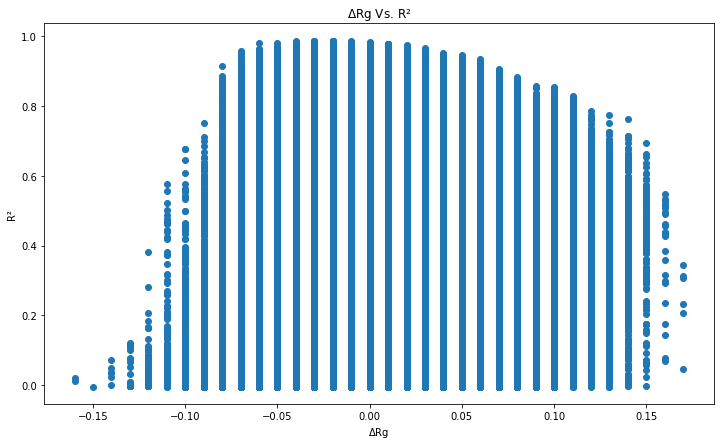

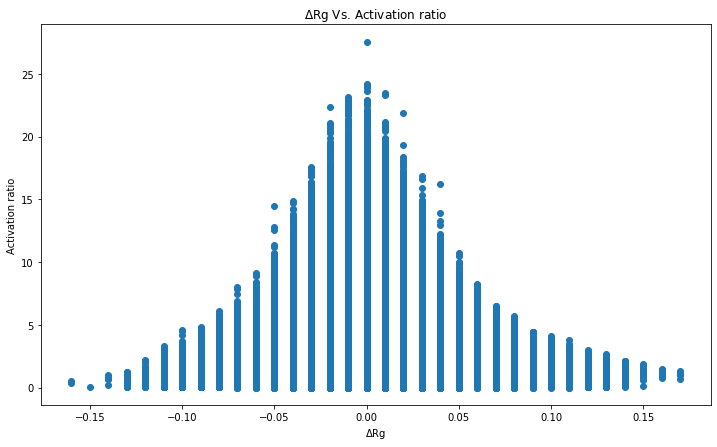

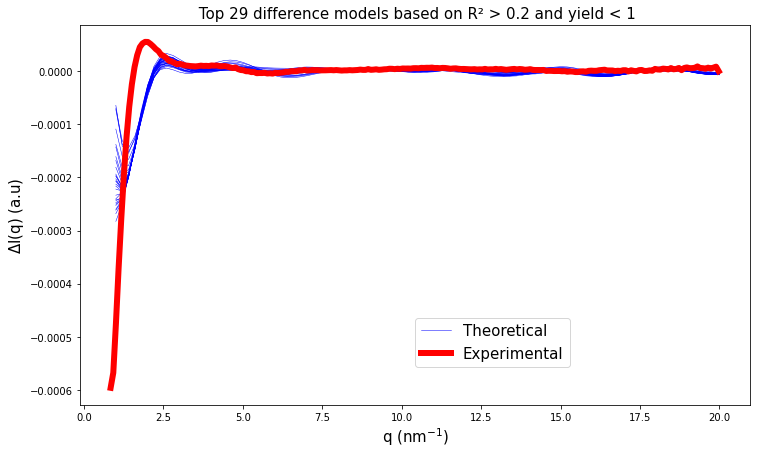

In [12]:
start_n = 0
q_max = 20
q_min = np.nanmin(XFEL_data[0].q[10])
make_plots(100, q_max, q_min)


# Show scaling - For test plotting scaled curves

## Main func.

In [58]:
def plot_scaled(n,light, dark, data, r2, activation_factor, abs_scale, diff_scale):
    # Plots an example curves to see if the scaling is working
    
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(24, 7))
    random_indices = [145]
    for i in random_indices: 

        scale_abs = abs_scale[i]
        scale_diff = diff_scale[i]
        light_index = light[i]
        dark_index = dark[i]
        dark_model = data[dark_index]
        light_model = data[light_index]
        
        diff = calc_diff(light_model, dark_model)
        diff = diff.scale_q(10)
        diff = diff.cut_q(XFEL_dark.q[0],np.max(diff.q))
        
        dark_model = dark_model.scale_q(10)
        dark_model = dark_model.cut_q(XFEL_dark.q[0],np.max(10))
        
        exp_dark = XFEL_dark_theo.cut_q(XFEL_dark.q[0], 10)
        
        ax1.plot(exp_dark.q, exp_dark.i*1e5/scale_abs, linewidth=3.0, color='Red', label='Experimental scaled to Theoretical')
        ax2.plot(XFEL_data[0].q, XFEL_data[0].i*1e5/scale_diff, linewidth=3.0, color='Red', label='Experimental scaled to Theoretical')
        
        if i == random_indices[-1]:
            ax1.plot(dark_model.q, dark_model.i, linewidth=3.0, color='Blue', label='Theoretical')
            ax2.plot(diff.q, diff.i, linewidth=3.0, color='Blue', label='Theoretical')
        else:
            ax1.plot(dark_model.q, dark_model.i, linewidth=3.0, color='Blue', )
            ax2.plot(diff.q, diff.i, linewidth=3.0, color='Blue')
  
   
             
    ax1.legend(loc=(0.5,0.2), frameon = True,fontsize=10)
    #ax1.set_yscale('log')
    #ax1.set_xlim([0,10])
    ax1.set_title(' Exp. abs. signal scaled to Theoretical abs. signal', fontsize=15)
    ax1.set_ylabel('I$_{abs}$(s) [cm$^{-1}$]/c[mg/ml]',fontsize=15)
    ax1.set_xlabel('q (nm$^{-1}$)',fontsize=15)
    #plt.savefig(f'/home/leonardo/Solution_Scattering_2208/Plots/Scale_abs.png',bbox_inches='tight',facecolor=(1, 1, 1))
    
    ax2.legend(loc=(0.5,0.2), frameon = True,fontsize=10)
    #ax2.set_xlim([0.8,20])
    ax2.set_title(f' Exp. diff signal scaled to Theoretical diff. signal', fontsize=15)
    ax2.set_ylabel('I$_{abs}$(s) [cm$^{-1}$]/c[mg/ml]',fontsize=15)
    ax2.set_xlabel('q (nm$^{-1}$)',fontsize=15)
    plt.savefig(f'/home/leonardo/Solution_Scattering_2208/Plots/Scaled_Example.png',bbox_inches='tight',facecolor=(1, 1, 1))
    
  
    print('R² of curve is:',r2[i])
    print('Absolute scale of curve is:', round(1e5/scale_abs[0],3))
    print('Difference scale of curve is:', round(1e5/scale_diff[0]*1e5,3))
    print(random_indices)
   

    

## Plot

R² of curve is: 0.8284300994148827
Absolute scale of curve is: 146898490.848
Difference scale of curve is: 4292997048564.538
[145]


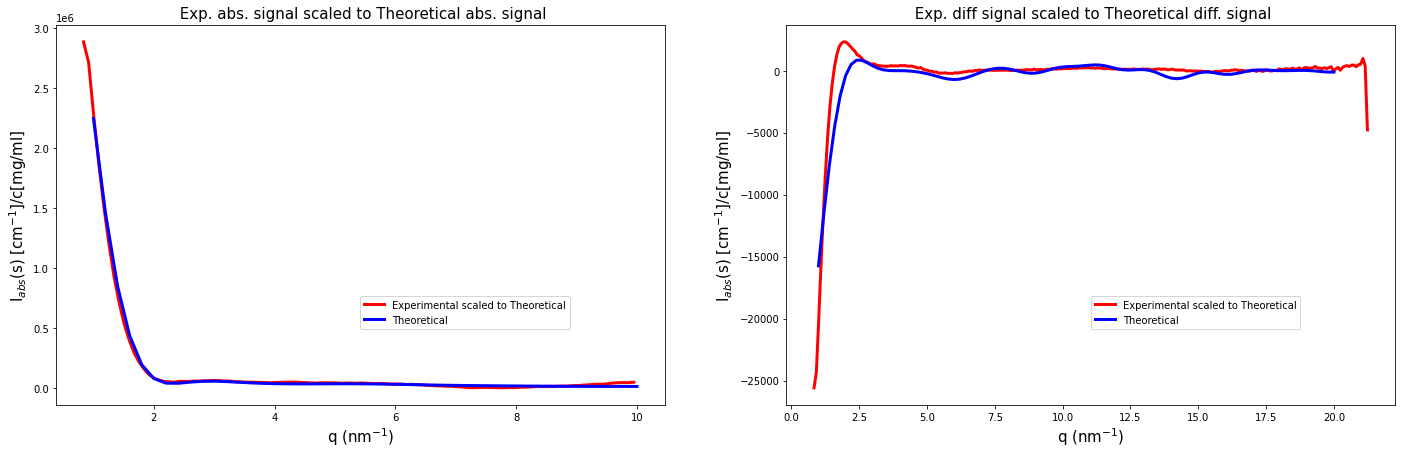

In [59]:
r2 = np.load(f'{data_dir}/R2.npy')
light_index = np.load(f'{data_dir}/light_index.npy')
dark_index = np.load(f'{data_dir}/dark_index.npy')
activation_factor = np.load(f'{data_dir}/occupancy.npy')
abs_scale = np.load(f'{data_dir}/abs_scales.npy')
diff_scale = abs(np.load(f'{data_dir}/diff_scales.npy'))


145
plot_scaled(1,light_index, dark_index, AF2_data, r2, activation_factor, abs_scale, diff_scale)

# Estimate activation factor FEB 23

## Dark 

In [145]:
q_min, qmax = [XFEL_dark.q[0],3]


dark_exp = XFEL_dark.cut_q(q_min,q_max)
dark_10sec = SAXS_dark_steady[0].scale_q(10)
dark_10sec = dark_10sec.cut_q(q_min,q_max)


xfel_interpolated_dark = interpolate(dark_10sec.q, dark_exp)
dark_scale = chi_square(dark_10sec.i,xfel_interpolated_dark.i,dark_10sec.error)[0]

print(dark_scale[0])
1/dark_scale[0]

Optimization terminated successfully.
         Current function value: 210.121318
         Iterations: 21
         Function evaluations: 42
3.704833984375


0.2699176276771005

### Plot

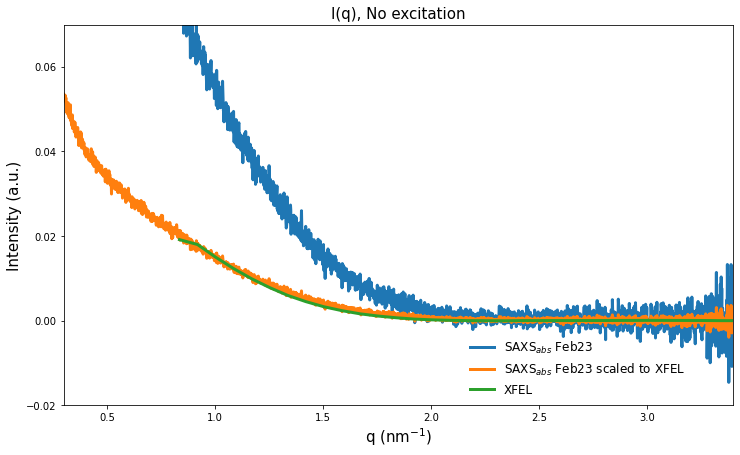

In [146]:
#Plot the dark data from XFEL averaged over runs [172,174,175,1756,180], only dark corresponding to last timepoints taken. 

fig, ax = plt.subplots(1, 1, figsize=(12, 7))
#ax.plot(q_dark, exp_interpolated_dark,linewidth=3.0, label='XFEL_interpolated') 
ax.plot(SAXS_dark_steady[0].q*10, SAXS_dark_steady[0].i,linewidth=3.0, label='SAXS$_{abs}$ Feb23')
ax.plot(SAXS_dark_steady[0].q*10, SAXS_dark_steady[0].i/dark_scale,linewidth=3.0, label='SAXS$_{abs}$ Feb23 scaled to XFEL')
ax.plot(XFEL_dark.q, XFEL_dark.i,linewidth=3.0, label='XFEL')


ax.legend(loc=(0.6,0.01), frameon = False,fontsize=12)
ax.set_title(r'I(q), No excitation',fontsize=15)
ax.set_ylabel('Intensity (a.u.)',fontsize=15)
ax.set_xlabel('q (nm$^{-1}$)',fontsize=15)
ax.set_ylim([-.02,.07])
#ax.set_yscale('log')
ax.set_xlim([0.3,3.4])
plt.savefig(f'/home/leonardo/Solution_Scattering_2208/plots/Dark_scaled_SAXS_FEB23',bbox_inches='tight',facecolor=(1, 1, 1))

## Diff

In [149]:
diff_exp = XFEL_data[0]

diff_exp = diff_exp.cut_q(q_min,q_max)
diff_10sec = SAXS_diff_steady[0]
diff_10sec = diff_10sec.scale_q(10)
diff_10sec = diff_10sec.cut_q(q_min, q_max)


exp_interpolated_diff = interpolate(diff_10sec.q,diff_exp)
diff_scale = chi_square(diff_10sec.i,exp_interpolated_diff.i,diff_10sec.error)[0]
print(diff_scale)
1/diff_scale[0]

Optimization terminated successfully.
         Current function value: 325.053687
         Iterations: 16
         Function evaluations: 32
[19.4621582]


0.05138176298656497

### Plot

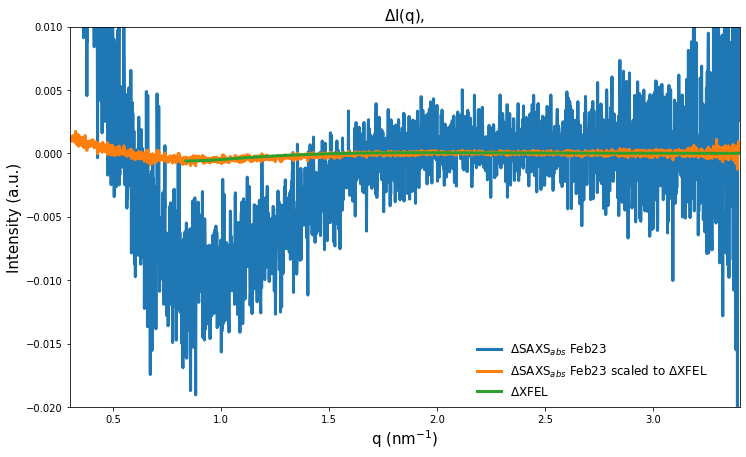

In [159]:
#Plot the dark data from XFEL averaged over runs [172,174,175,1756,180], only dark corresponding to last timepoints taken. 

fig, ax = plt.subplots(1, 1, figsize=(12, 7))
#ax.plot(q_dark, exp_interpolated_dark,linewidth=3.0, label='XFEL_interpolated') 
ax.plot(SAXS_diff_steady[0].q*10, SAXS_diff_steady[0].i,linewidth=3.0, label=r'$\Delta$SAXS$_{abs}$ Feb23')
ax.plot(SAXS_diff_steady[0].q*10, SAXS_diff_steady[0].i*1/diff_scale[0],linewidth=3.0, label='$\Delta$SAXS$_{abs}$ Feb23 scaled to $\Delta$XFEL')
ax.plot(XFEL_data[0].q, XFEL_data[0].i,linewidth=3.0, label='$\Delta$XFEL')


ax.legend(loc=(0.6,0.01), frameon = False,fontsize=12)
ax.set_title(r'$\Delta$I(q), ',fontsize=15)
ax.set_ylabel('Intensity (a.u.)',fontsize=15)
ax.set_xlabel('q (nm$^{-1}$)',fontsize=15)
ax.set_ylim([-.02,.01])
ax.set_xlim([0.3,3.4])
plt.savefig(f'/home/leonardo/Solution_Scattering_2208/plots/Diff_scaled_SAXS_FEB23',bbox_inches='tight',facecolor=(1, 1, 1))

### Calc activation factor

In [161]:
# Based on scaling XFEL to exp. 
#
#
activation_factor = (dark_scale/diff_scale)

print(activation_factor[0])
print(1/activation_factor[0])

0.1903609016897274
5.253179571663921


### Plot Illumination series 

## Plot comparison of diff data, abs data and excited data. 

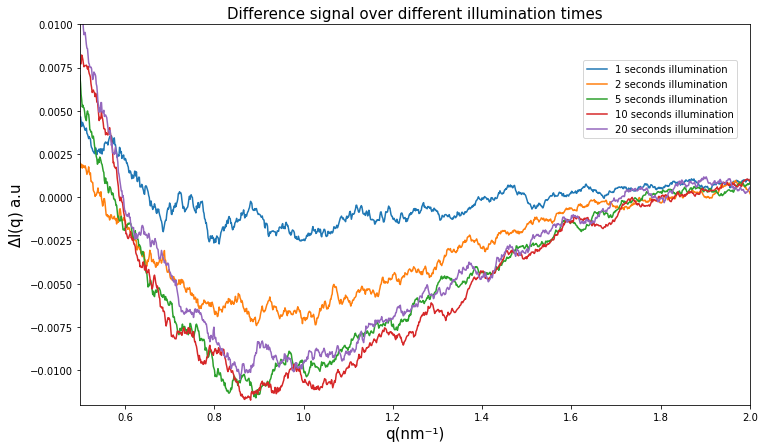

In [164]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
ax.set_title('Difference signal over different illumination times', fontsize=15)
ax.set_xlabel(r'q(nm⁻¹)',fontsize=15)
ax.set_ylabel(f'$\Delta$I(q) a.u', fontsize=15)
    
for data, time in zip(SAXS_diff_illumination, time_illumination):
    data = data.scale_q(10)
    data = data.remove_nan()
    data_smooth = savgol_filter(data.i, window_length=30, polyorder=1)
    ax.plot(data.q, data_smooth, label=f'{time} seconds illumination')
    #ax.plot(data.q,data.i, label=f'{time} seconds illumination')
    


twenty = SAXS_diff_steady[3].scale_q(10)
twenty_smooth = savgol_filter(twenty.i, window_length=30, polyorder=1)
ax.plot(twenty.q, twenty_smooth, label=f'20 seconds illumination')    


ax.legend(loc=(0.75,0.7), frameon = True,fontsize=10)
ax.set_ylim([-.012,.01])
ax.set_xlim([0.5,2])
plt.show()

    


# Test with Unfolded Helix from Collabfold


### Load curve based on data from collab prediction with every 2nd reisude mutated to Glycine (Dark used is the same , mutations done in coot)

## Func. for testing changes in sequence

In [65]:
# Def func.

def calc_activation_AF2(q_min, q_max, path_models, path_abs, data_name):
    
    
    
    files = [os.path.join(path_models, file) for file in os.listdir(path_models)]
    
    
    # Figurers for plotting 
    fig, (ax1 ,ax2) = plt.subplots(1, 2, figsize=(24, 7))    
    # Pre-processing the data 
    models = [ScatterData(file) for file in files]
    models = [data.scale_q(10) for data in models]
    models = [data.cut_q(q_min,q_max) for data in models]
    
    abs_theory = ScatterData(path_abs)
    abs_theory = abs_theory.scale_q(10)
    abs_theory = abs_theory.cut_q(q_min, q_max)

    
    # Interpolat exp abs data
    interpolated_abs = interpolate(abs_theory.q, XFEL_dark_theo)
    # Calc scale factor 
    scale_abs,fopt_abs = SSE(interpolated_abs.i, abs_theory.i, 0.1)
    # Calc difference
    differences= [calc_diff(model, abs_theory) for model in models]
    
    r2 = np.zeros((len(differences)))
    corr = np.zeros((len(differences)))
    activation = np.zeros((len(differences)))
    
    for i,diff in enumerate(differences): 
        
        # Interpolate exp diff data
        exp_interpolated = interpolate(diff.q, XFEL_data[0])
        
        # Calc scale factor 
        scale_diff,fopt_diff = SSE(exp_interpolated.i, diff.i, scale_abs*.1)
        
        # Calculate the R2 between intepolated experimental curve and the theoretical curve
        r2[i] = calc_r2(exp_interpolated.i, diff.i * scale_diff)

        # PCC
        corr[i] = np.corrcoef(exp_interpolated.i,diff.i*scale_diff, rowvar=True)[0][1]
        
        # Calc occupance
        activation[i] = (scale_diff/scale_abs)[0]
            

    

        # subplot1 
        if i == r2.shape[0] - 1:
            ax2.plot(diff.q,diff.i, label = f'$\Delta$Theory', color='blue')
        else: 
            ax2.plot(diff.q,diff.i, color='blue')
        

    ax2.plot(exp_interpolated.q,exp_interpolated.i/scale_abs, label = '$\Delta$XFEL scaled to Theory abs.', color = 'red', linewidth = 3)
    ax2.plot(exp_interpolated.q,exp_interpolated.i/scale_diff, label = '$\Delta$XFEL scaled to $\Delta$Theory', color = 'green', linewidth = 3)
    ax2.legend(loc=(0.5,0.1), frameon = True,fontsize=13)
    ax2.set_title(f'Comparing Exp.diff.scattering to Theoretical diff: {data_name}', fontsize=15)
    ax2.set_ylabel('$\Delta$I(q)', fontsize=15)
    ax2.set_xlabel(r'q (nm⁻¹)', fontsize=15)
    
    
    
    ax1.plot(interpolated_abs.q,interpolated_abs.i/scale_abs, label = 'XFEL scaled to Theory abs.', color = 'red', linewidth = 2)
    ax1.plot(abs_theory.q,abs_theory.i, label = 'Theory abs.', color = 'blue', linewidth = 2)
    ax1.legend(loc=(0.5,0.1), frameon = True,fontsize=13)
    ax1.set_title(f'Comparing exp. absolute to theoretical: {data_name}', fontsize=15)
    ax1.set_ylabel('I(q)', fontsize=15)
    ax1.set_xlabel(r'q (nm⁻¹)', fontsize=15)
    
    plot_r2_activation(r2, activation, '', save=False)
    
    

## Test for insertion of glycines (every 2nd and every 6th position in J$\alpha$-helix)

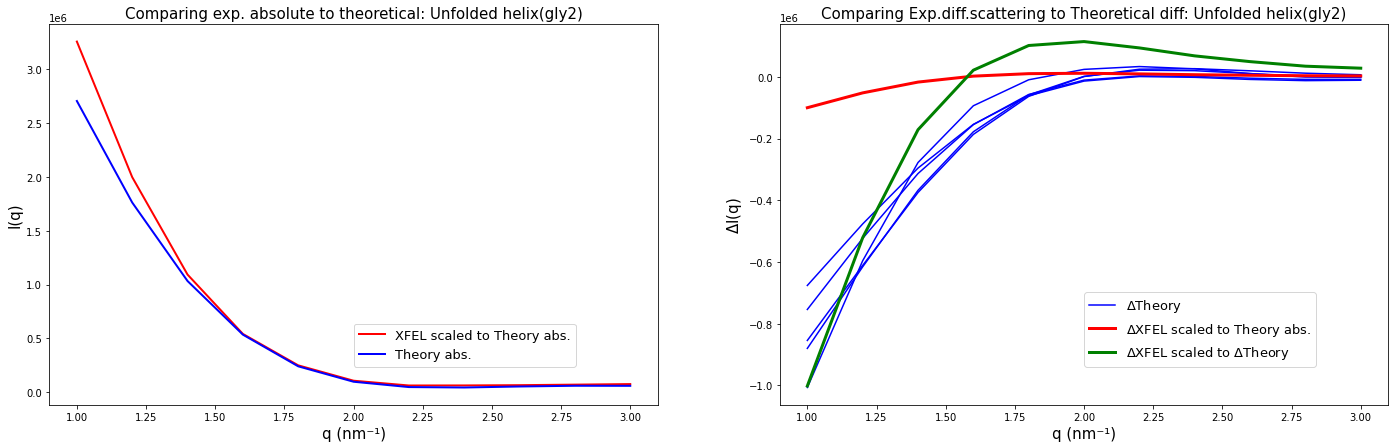

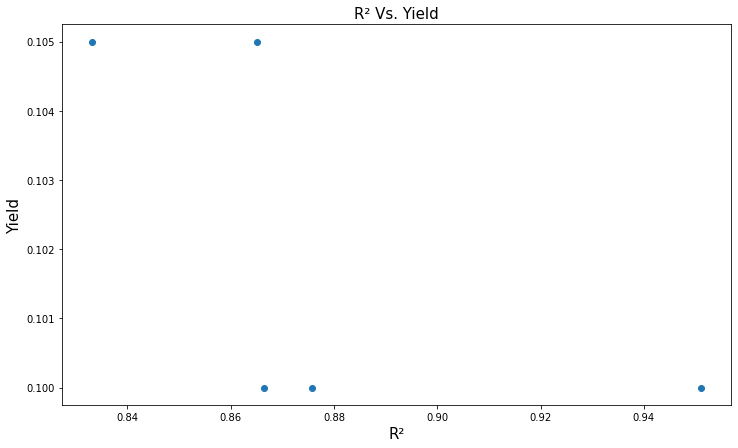

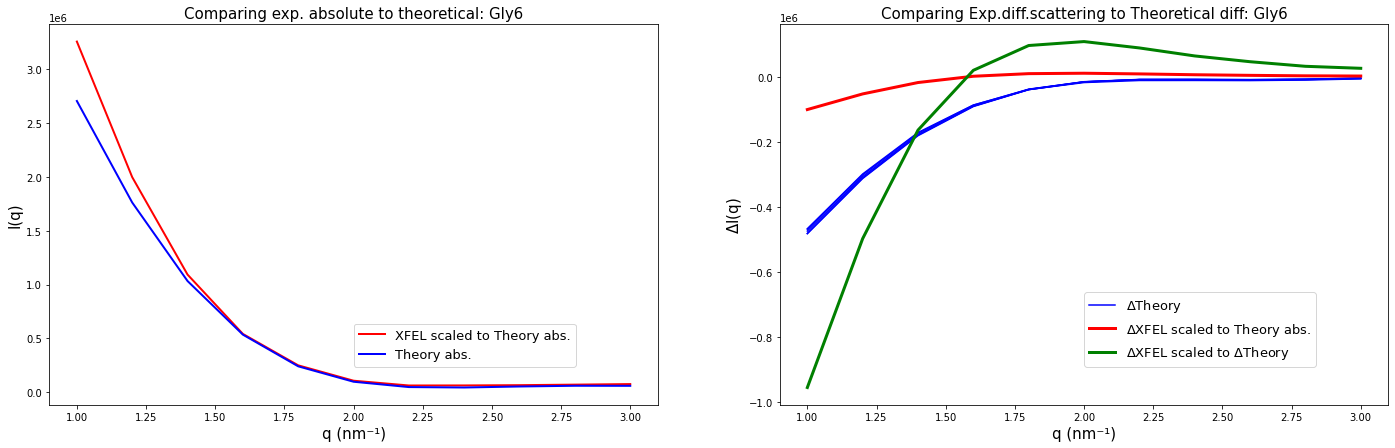

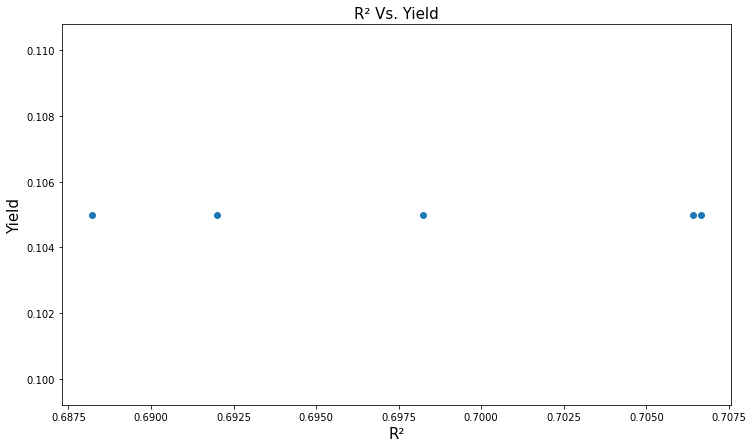

In [66]:
#q_min, q_max = (XFEL_data[0].q[10], 6)
q_min, q_max = (1, 3)
gly2 = '/home/leonardo/Solution_Scattering_2208/AsLOV2/CollabFold_predictions/gly2/intensities'
gly6 = '/home/leonardo/Solution_Scattering_2208/AsLOV2/CollabFold_predictions/gly6'
path_abs = ('/home/leonardo/Solution_Scattering_2208/AsLOV2/CollabFold_predictions/refs/No_helix/fixed/gly2_mut.txt')
calc_activation_AF2(q_min, q_max, gly2, path_abs, 'Unfolded helix(gly2)')
calc_activation_AF2(q_min, q_max, gly6, path_abs, 'Gly6')

## Test for insertion of mutations

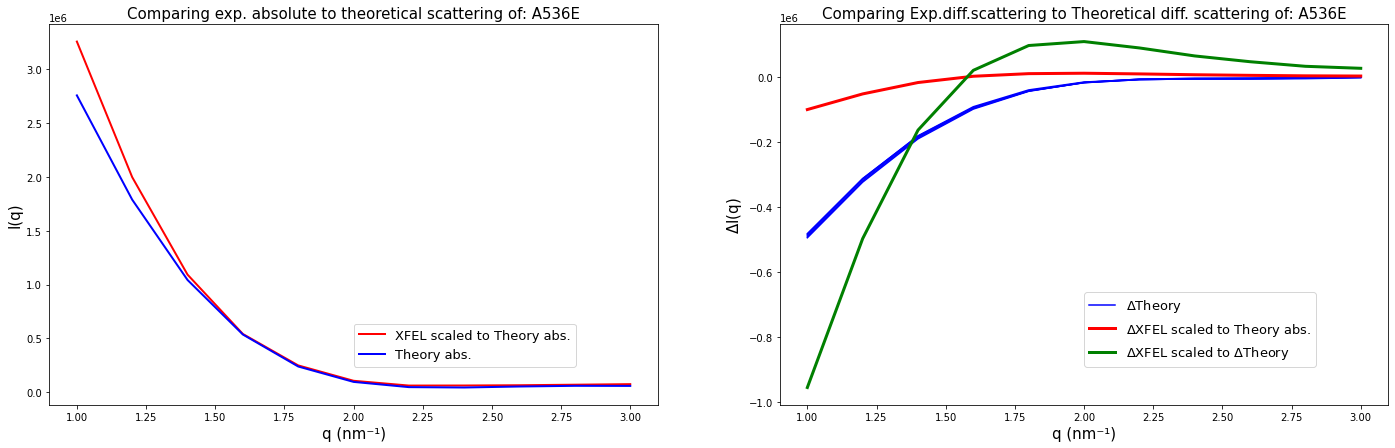

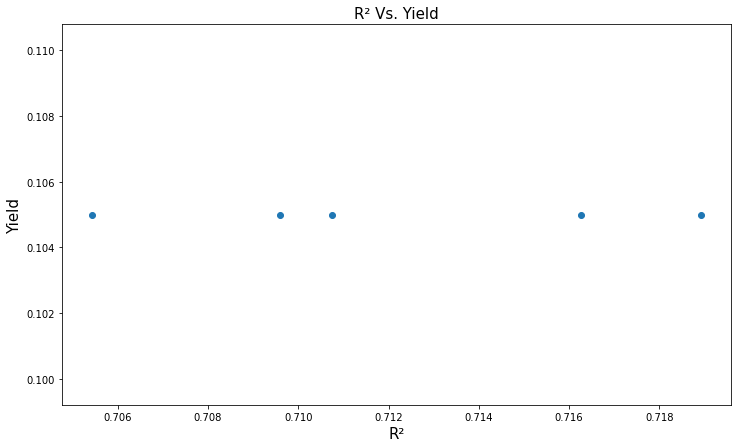

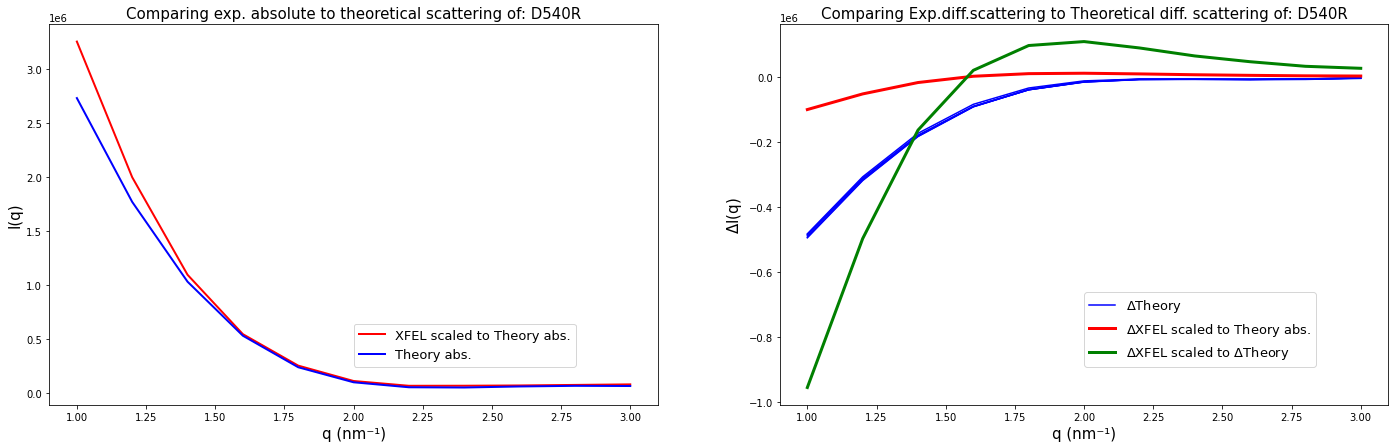

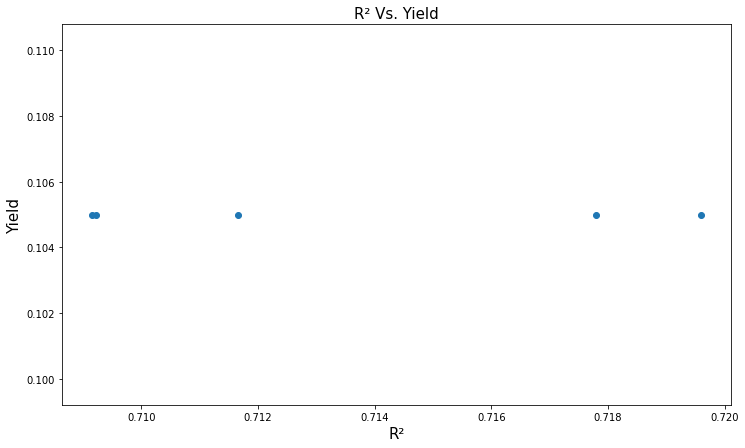

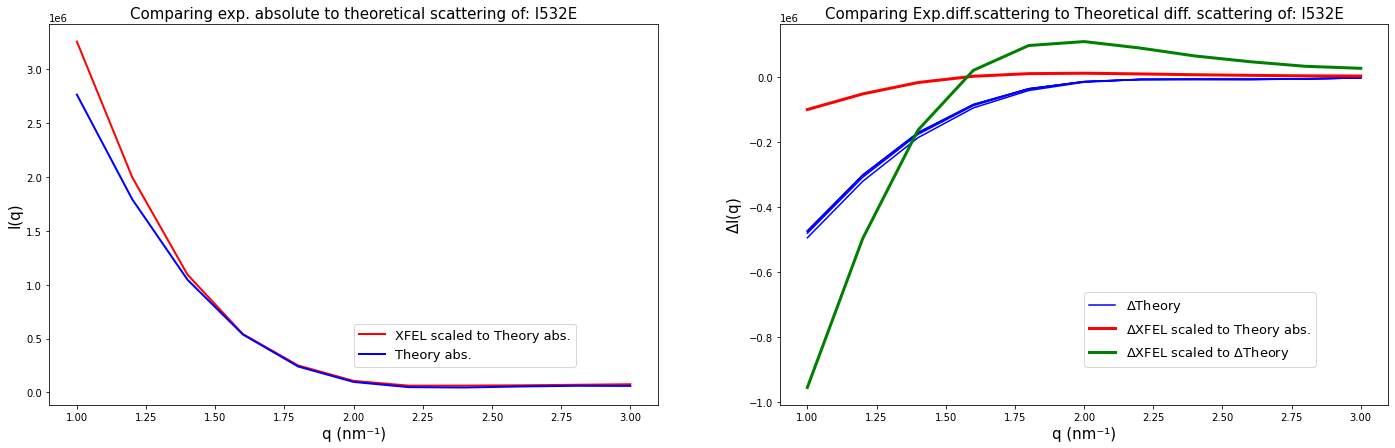

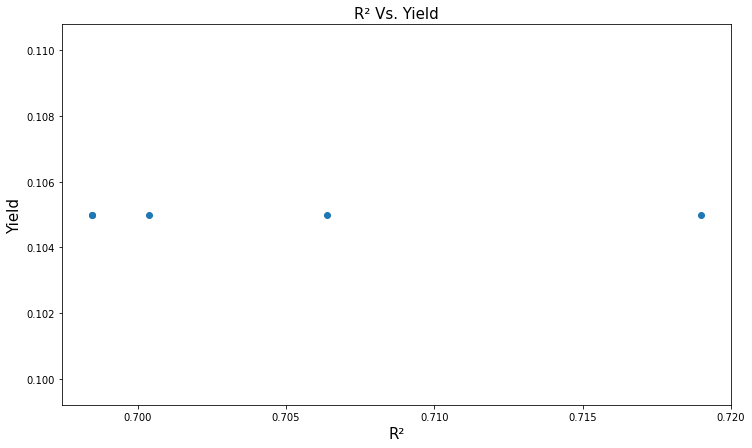

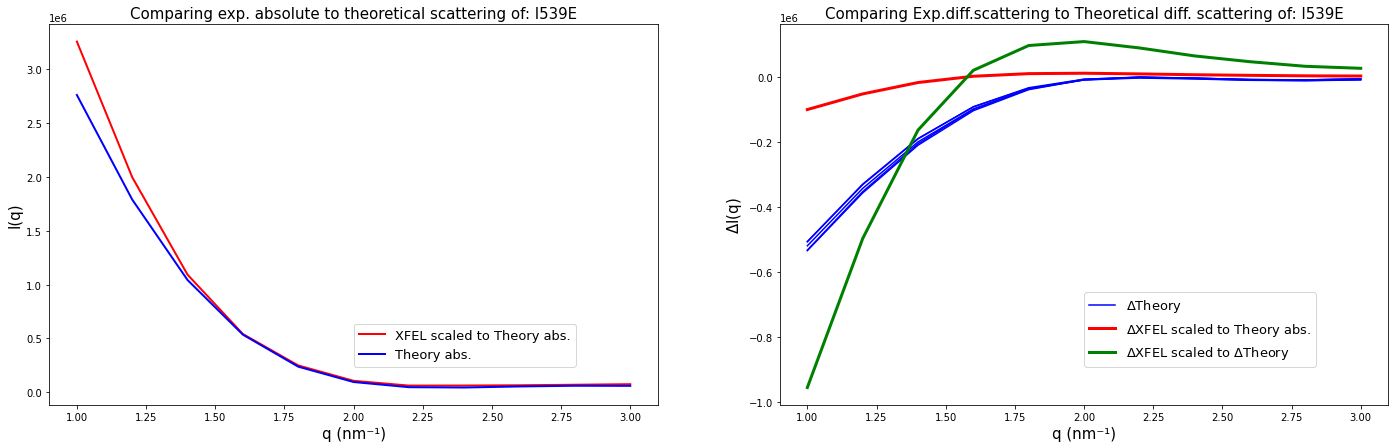

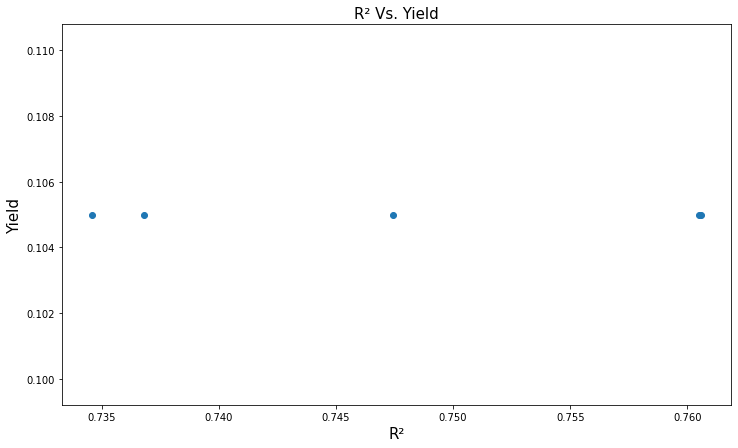

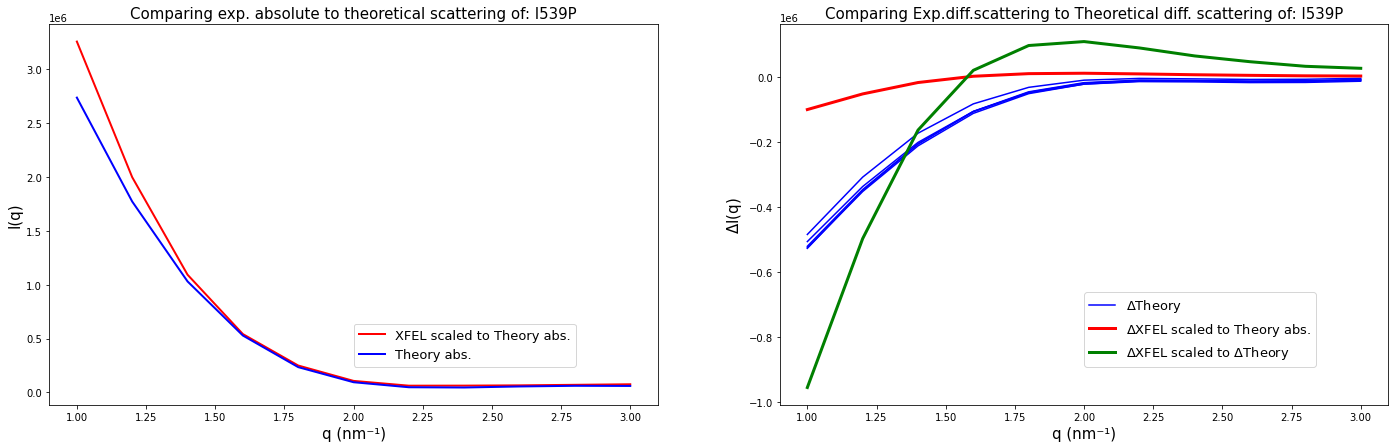

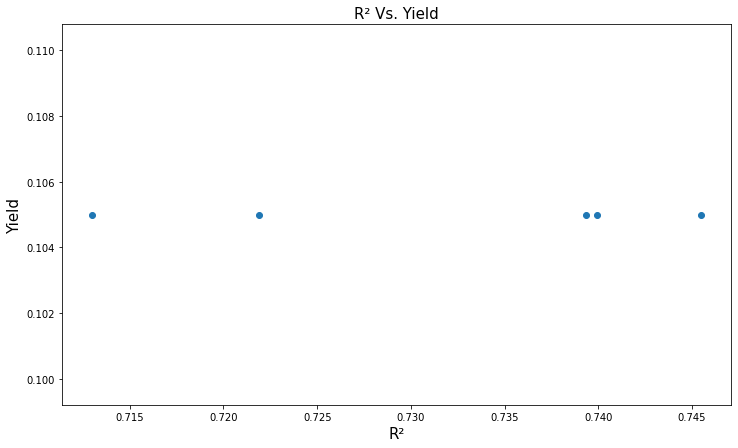

In [8]:
path_A536E = '/home/leonardo/Solution_Scattering_2208/AsLOV2/CollabFold_predictions/A536E/fixed'
path_D540R = '/home/leonardo/Solution_Scattering_2208/AsLOV2/CollabFold_predictions/D540R/fixed'
path_I532E = '/home/leonardo/Solution_Scattering_2208/AsLOV2/CollabFold_predictions/I532E/fixed'
path_I539E = '/home/leonardo/Solution_Scattering_2208/AsLOV2/CollabFold_predictions/I539E/fixed'
path_I539P = '/home/leonardo/Solution_Scattering_2208/AsLOV2/CollabFold_predictions/I539P/fixed'

path_A536E_ref = ('/home/leonardo/Solution_Scattering_2208/AsLOV2/CollabFold_predictions/refs/fixed/A536E.txt')
path_D540R_ref = ('/home/leonardo/Solution_Scattering_2208/AsLOV2/CollabFold_predictions/refs/fixed/D540R.txt')
path_I532E_ref = ('/home/leonardo/Solution_Scattering_2208/AsLOV2/CollabFold_predictions/refs/fixed/I532E.txt')
path_I539E_ref = ('/home/leonardo/Solution_Scattering_2208/AsLOV2/CollabFold_predictions/refs/fixed/I539E.txt')
path_I539P_ref = ('/home/leonardo/Solution_Scattering_2208/AsLOV2/CollabFold_predictions/refs/fixed/I539P.txt')

calc_activation_AF2(q_min, q_max, path_A536E, path_A536E_ref, 'A536E')
calc_activation_AF2(q_min, q_max, path_D540R, path_D540R_ref, 'D540R')
calc_activation_AF2(q_min, q_max, path_I532E, path_I532E_ref, 'I532E')
calc_activation_AF2(q_min, q_max, path_I539E, path_I539E_ref, 'I539E')
calc_activation_AF2(q_min, q_max, path_I539P, path_I539P_ref, 'I539P')

## Scale Theory to SAXS to see if same activation

In [173]:
# Def func.

def calc_activation_AF2_SAXS(q_min, q_max, path_models, path_abs, data_name):
    
    
    
    files = [os.path.join(path_models, file) for file in os.listdir(path_models)]
    
    SAXS_diff = SAXS_diff_steady[0]
    SAXS_diff = SAXS_diff.scale_q(10)
    SAXS_diff = SAXS_diff.cut_q(q_min,q_max)
    
    SAXS_abs = SAXS_dark_steady[0]
    SAXS_abs = SAXS_abs.scale_q(10)
    SAXS_abs = SAXS_abs.cut_q(q_min, q_max)
    
    
    # Figurers for plotting 
    fig, (ax1 ,ax2) = plt.subplots(1, 2, figsize=(24, 7))    
    # Pre-processing the data 
    models = [ScatterData(file) for file in files]
    models = [data.scale_q(10) for data in models]
    models = [data.cut_q(q_min,q_max) for data in models]
    
    abs_theory = ScatterData(path_abs)
    abs_theory = abs_theory.scale_q(10)
    abs_theory = abs_theory.cut_q(q_min, q_max)

    
    # Interpolat exp abs data
    interpolated_abs = interpolate(abs_theory.q, SAXS_abs)
    # Calc scale factor 
    scale_abs,fopt_abs = SSE(interpolated_abs.i, abs_theory.i, 1)
    # Calc difference
    differences= [calc_diff(model, abs_theory) for model in models]
    
    r2 = np.zeros((len(differences)))
    corr = np.zeros((len(differences)))
    activation = np.zeros((len(differences)))
    
    
    
    for i,diff in enumerate(differences): 
        
        # Interpolate exp diff data
        exp_interpolated = interpolate(diff.q, SAXS_diff)
        
        # Calc scale factor 
        scale_diff,fopt_diff = SSE(exp_interpolated.i, diff.i, scale_abs)
        
        # Calculate the R2 between intepolated experimental curve and the theoretical curve
        r2[i] = calc_r2(exp_interpolated.i, diff.i * scale_diff)

        # PCC
        corr[i] = np.corrcoef(exp_interpolated.i,diff.i*scale_diff, rowvar=True)[0][1]
        
        # Calc occupance
        activation[i] = (scale_diff/scale_abs)[0]            
    
       
        # subplot1 
        if i == r2.shape[0] - 1:
            ax2.plot(diff.q,diff.i, label = f'$\Delta$Theory', color='blue')
        else: 
            ax2.plot(diff.q,diff.i, color='blue')
        
 
    ax2.plot(exp_interpolated.q,exp_interpolated.i/scale_abs, label = '$\Delta$SAXS scaled to Theory abs.', color = 'red', linewidth = 3)
    ax2.plot(exp_interpolated.q,exp_interpolated.i/scale_diff, label = '$\Delta$SAXS scaled to $\Delta$Theory', color = 'green', linewidth = 3)
    ax2.legend(loc=(0.5,0.1), frameon = True,fontsize=13)
    ax2.set_title(f'Comparing Exp.diff.scattering to Theoretical diff: {data_name}', fontsize=15)
    ax2.set_ylabel('$\Delta$I(q)', fontsize=15)
    ax2.set_xlabel(r'q (nm⁻¹)', fontsize=15)
    
   
    ax1.plot(interpolated_abs.q,interpolated_abs.i/scale_abs, label = 'SAXS scaled to Theory abs.', color = 'red', linewidth = 2)
    ax1.plot(abs_theory.q,abs_theory.i, label = 'Theory abs.', color = 'blue', linewidth = 2)
    ax1.legend(loc=(0.5,0.1), frameon = True,fontsize=13)
    ax1.set_title(f'Comparing exp. absolute to theoretical: {data_name}', fontsize=15)
    ax1.set_ylabel('I(q)', fontsize=15)
    ax1.set_xlabel(r'q (nm⁻¹)', fontsize=15)
    
    plot_r2_activation(r2, activation, '')
    
    

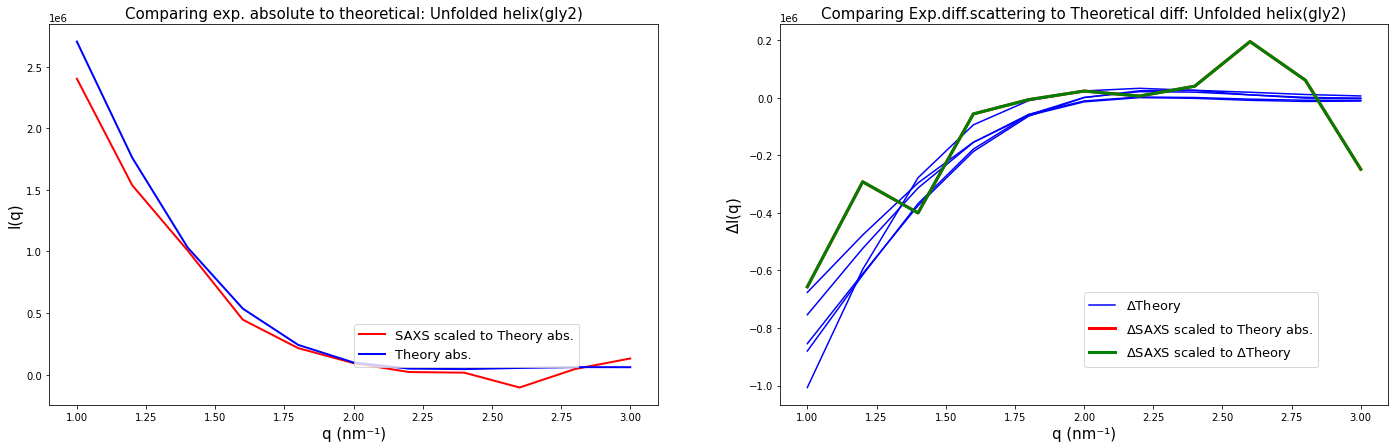

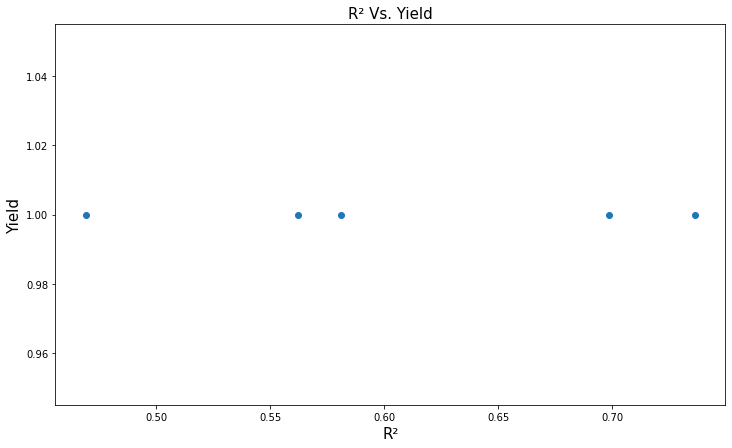

In [174]:
q_min, q_max = (1, 3)
gly2 = '/home/leonardo/Solution_Scattering_2208/AsLOV2/CollabFold_predictions/gly2/intensities'
gly6 = '/home/leonardo/Solution_Scattering_2208/AsLOV2/CollabFold_predictions/gly6'
path_abs = ('/home/leonardo/Solution_Scattering_2208/AsLOV2/CollabFold_predictions/refs/No_helix/fixed/gly2_mut.txt')
calc_activation_AF2_SAXS(q_min, q_max, gly2, path_abs, 'Unfolded helix(gly2)')

## Diff map test

In [317]:
path_ref = '/home/leonardo/Solution_Scattering_2208/AsLOV2/CollabFold_predictions/test_DED/test/aligned/ref.map.ccp4'
path_unfolded = '/home/leonardo/Solution_Scattering_2208/AsLOV2/CollabFold_predictions/test_DED/test/aligned/unfold.map.ccp4'

dark = mrcfile.open(path_ref) 
unfolded = mrcfile.open(path_unfolded) 
#dark.print_header()
#unfolded.print_header()

scale_map = SSE(dark.data, unfolded.data, 2)[0]
#ppc = np.corrcoef(dark.data,unfolded.data*scale_map, rowvar=True)
scaled_unfolded = unfolded.data * scale_map
new = mrcfile.open('/home/leonardo/Solution_Scattering_2208/AsLOV2/CollabFold_predictions/test_DED/test/aligned/diff_map.ccp4',mode='r+')
diff_data = (scaled_unfolded-dark.data).astype('float32')
new.set_data(diff_data)
new.update_header_stats()
new.header['machst'] = np.array([68, 65,  0,  0])
new.header['mx'] = 80
new.header['my'] = 128
new.header['mz'] = 152


#new.print_header()
#new.set_data(unfolded.data-dark.data)
new.close()
dark.close()
unfolded.close()


# For presentation 

## Make image of how amplitude of diff curves change with magnitude of change

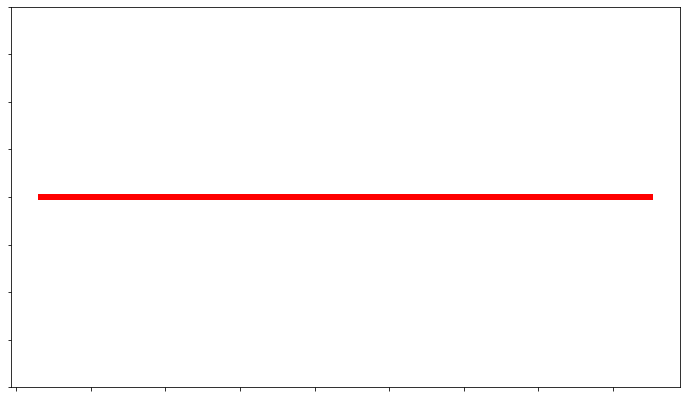

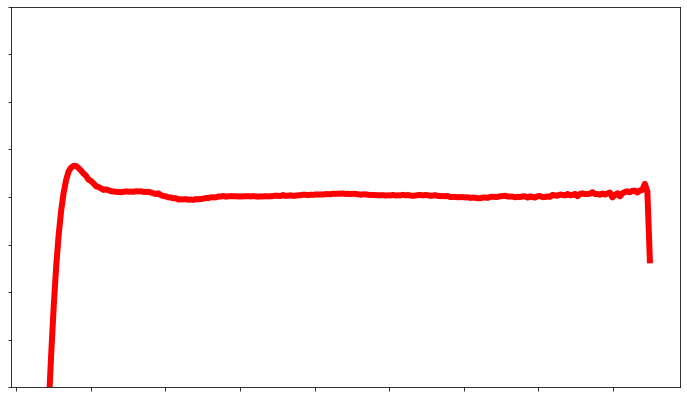

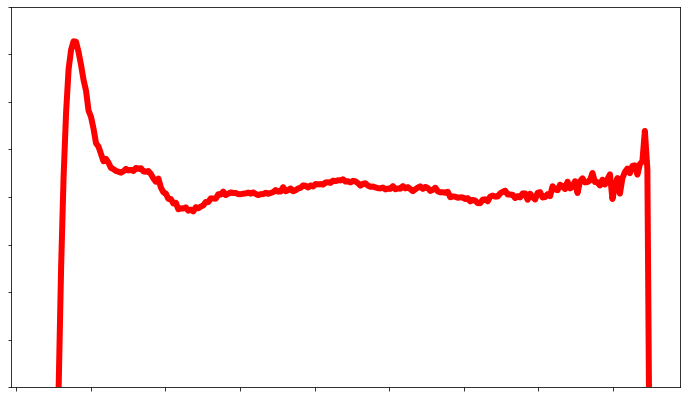

In [74]:
save_path = '/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/new_note_book/plots'

fig, ax1 = plt.subplots(1, 1, figsize=(12, 7)) 
ax1.plot(XFEL_data[0].q, XFEL_data[0].i * 0, linewidth=6.0, color='Red')
ax1.set_ylim([-.001,.001])
ax1.set_yticklabels([])
ax1.set_xticklabels([])

plt.savefig(f'{save_path}/for_presentation1.png',bbox_inches='tight',facecolor=(1, 1, 1))  


fig, ax2 = plt.subplots(1, 1, figsize=(12, 7)) 
ax2.plot(XFEL_data[0].q, XFEL_data[0].i*3, linewidth=6.0, color='Red')
ax2.set_ylim([-.001,.001])
ax2.set_yticklabels([])
ax2.set_xticklabels([])
plt.savefig(f'{save_path}/for_presentation2.png',bbox_inches='tight',facecolor=(1, 1, 1))  

fig, ax3 = plt.subplots(1, 1, figsize=(12, 7)) 
ax3.plot(XFEL_data[0].q, XFEL_data[0].i*15 , linewidth=6.0, color='Red')
ax3.set_ylim([-.001,.001])
ax3.set_yticklabels([])
ax3.set_xticklabels([])
plt.savefig(f'{save_path}/for_presentation3.png',bbox_inches='tight',facecolor=(1, 1, 1))  

In [2177]:
light_h=np.sum(avg_S_on[150:175,:],axis = 0)/25
light_h = light_h - buffer_on*0.935
interpolated_h_light = interpolate_curve(diamond_q*10,hamburg_q,light_h)
solution_light = sse(light_I1,interpolated_h_light[0], E_light)
print(solution_light[0][0])
print(1/solution_light[0][0])

Optimization terminated successfully.
         Current function value: 5165.846266
         Iterations: 18
         Function evaluations: 36
5.025524902343747
0.19898418959850966


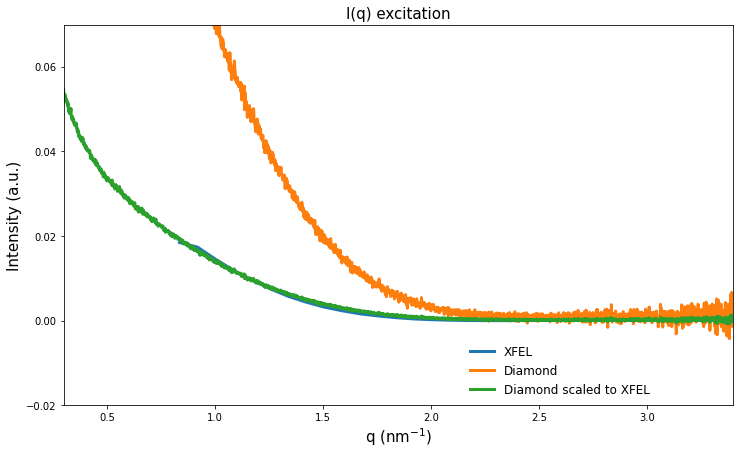

In [2178]:
#Plot the light data from XFEL averaged over runs [172,174,175,1756,180], only dark corresponding to last timepoints taken. 

fig, ax = plt.subplots(1, 1, figsize=(12, 7))
ax.plot(hamburg_q, light_h,linewidth=3.0, label='XFEL')
ax.plot(diamond_q*10, light_I1,linewidth=3.0, label='Diamond')
ax.plot(diamond_q*10, light_I1*1/solution_light[0][0],linewidth=3.0, label='Diamond scaled to XFEL')


ax.legend(loc=(0.6,0.01), frameon = False,fontsize=12)
ax.set_title(r'I(q) excitation',fontsize=15)
ax.set_ylabel('Intensity (a.u.)',fontsize=15)
ax.set_xlabel('q (nm$^{-1}$)',fontsize=15)
ax.set_ylim([-.02,.07])
ax.set_xlim([0.3,3.4])
plt.savefig(f'/home/leonardo/SAXS_222711/Plots/excitation',bbox_inches='tight',facecolor=(1, 1, 1))

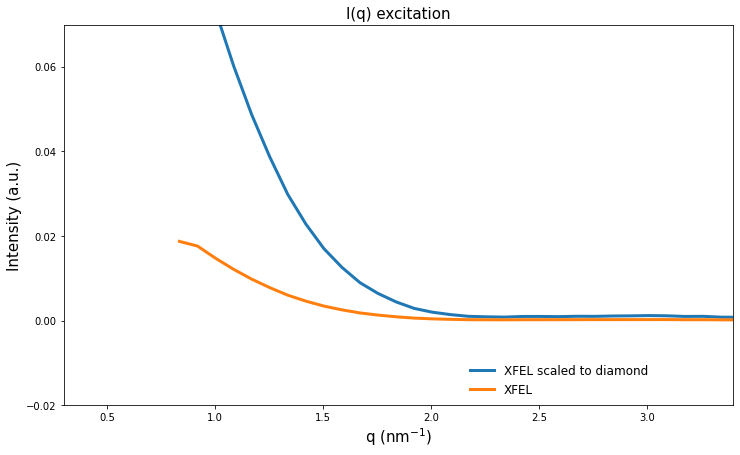

In [2153]:
#Plot the light data from XFEL averaged over runs [172,174,175,1756,180], only dark corresponding to last timepoints taken. 

fig, ax = plt.subplots(1, 1, figsize=(12, 7))
ax.plot(hamburg_q,(light_h)*solution_dark[0][0],linewidth=3.0, label='XFEL scaled to diamond')
ax.plot(hamburg_q,(light_h),linewidth=3.0, label='XFEL')
#ax.plot(diamond_q*10, light_I1,linewidth=3.0, label='Diamond')




ax.legend(loc=(0.6,0.01), frameon = False,fontsize=12)
ax.set_title(r'I(q) excitation',fontsize=15)
ax.set_ylabel('Intensity (a.u.)',fontsize=15)
ax.set_xlabel('q (nm$^{-1}$)',fontsize=15)
ax.set_ylim([-.02,.07])
ax.set_xlim([0.3,3.4])
plt.savefig(f'/home/leonardo/SAXS_222711/Plots/No_excitation',bbox_inches='tight',facecolor=(1, 1, 1))

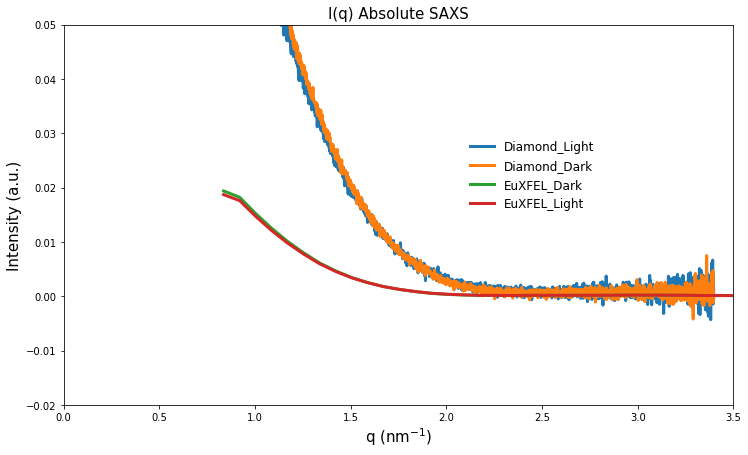

In [2152]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
#solution = sse(light_I1, dark_I1, E_diff)
#print(solution[0][0])

ax.plot(diamond_q*10, light_I1,linewidth=3.0, label='Diamond_Light')
ax.plot(diamond_q*10, dark_I1,linewidth=3.0, label='Diamond_Dark')


ax.plot(hamburg_q, dark_h,linewidth=3.0, label='EuXFEL_Dark')
ax.plot(hamburg_q, light_h,linewidth=3.0, label='EuXFEL_Light')

#ax.plot(diamond_q, dark_I1,linewidth=3.0, label='Diamond_Dark_scaled')
ax.legend(loc=(0.6,0.5), frameon = False,fontsize=12)
ax.set_title(r'I(q) Absolute SAXS',fontsize=15)
ax.set_ylabel('Intensity (a.u.)',fontsize=15)
ax.set_xlabel('q (nm$^{-1}$)',fontsize=15)#ax.set_ylim([-.02,.02])
ax.set_xlim([0,3.5])
ax.set_ylim([-.02,.05])
plt.savefig(f'/home/leonardo/SAXS_222711/Plots/Light_Dark_comparison',bbox_inches='tight',facecolor=(1, 1, 1))